In [1]:
import pandas as pd
import networkx as nx
import json
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import pprint

In [2]:
df = pd.read_csv("/content/sample_data/data_scopus.csv")
df

,Title,Year,EID,Abstract,Publisher,Conference name,Conference date,Authors,Author(s) ID,Authors with affiliations,Source title,Abbreviated Source Title,Cited by
0,Virtual reality applications for the built env...,2020,2-s2.0-85086464158,With its advanced capabilities of immersive an...,Elsevier B.V.,NaN,NaN,"Zhang Y., Liu H., Kang S.-C., Al-Hussein M.",57202536919;53984550800;57215426514;6603541102;,"Zhang, Y., Department of Civil and Environment...",Automation in Construction,Autom Constr,NaN
1,"Self-tracking while doing sport: Comfort, moti...",2020,2-s2.0-85082875828,The spread of wearable technologies is paving ...,Academic Press,NaN,NaN,"Rapp A., Tirabeni L.",23398572100;57191836654;,"Rapp, A., Computer Science Department, Univers...",International Journal of Human Computer Studies,Int J Hum Comput Stud,NaN
2,"Bridge damage: Detection, IFC-based semantic e...",2020,2-s2.0-85078194587,Building Information Modeling (BIM) representa...,Elsevier B.V.,NaN,NaN,"Isailović D., Stojanovic V., Trapp M., Richter...",57205293410;56421700900;24831175200;3619515940...,"Isailović, D., Department for Construction Pro...",Automation in Construction,Autom Constr,NaN
3,VR system for spatio-temporal visualization of...,2019,2-s2.0-85075706132,Social media analysis is helpful to understand...,Springer,NaN,NaN,"Okada K., Yoshida M., Itoh T., Czauderna T., S...",57201502480;57171240600;35373203100;2592569550...,"Okada, K., Ochanomizu University, Tokyo, Japan...",Multimedia Tools and Applications,Multimedia Tools Appl,NaN
4,DiseaSE: A biomedical text analytics system fo...,2019,2-s2.0-85074886243,Due to increasing volume and unstructured natu...,Academic Press Inc.,NaN,NaN,"Abulaish M., Parwez M.A., Jahiruddin",6505934038;57202719622;35590173900;,"Abulaish, M., Department of Computer Science, ...",Journal of Biomedical Informatics,J. Biomed. Informatics,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Propositional n-traces: visualizing a problem ...,1995,2-s2.0-0029533881,"As part of an inter-disciplinary effort, we ar...","IEEE, Los Alamitos, CA, United States",Proceedings of the 1995 6th Annual IEEE Confer...,29 October 1995 through 3 October 1995,"Prevost Nathalie, Jorgenson Loki, Jennings R.E...",6603428086;55937115800;16412349600;7003348138;,"Prevost, Nathalie, Simon Fraser Univ, Burnaby,...",Proceedings of the IEEE Visualization Conference,Proc IEEE Visual Conf,NaN
566,Fast algorithms for visualizing fluid motion i...,1995,2-s2.0-0029487213,The plotting of streamlines is an effective wa...,"IEEE, Los Alamitos, CA, United States",Proceedings of the 1995 6th Annual IEEE Confer...,29 October 1995 through 3 October 1995,"Ueng S.K., Sikorski K., Ma Kwan-Liu",7006871353;35194562700;35242602500;,"Ueng, S.K., Univ of Utah, Salt Lake City, Unit...",Proceedings of the IEEE Visualization Conference,Proc IEEE Visual Conf,10.0
567,Fast normal estimation using surface character...,1995,2-s2.0-0029488955,To visualize the volume data acquired from com...,"IEEE, Los Alamitos, CA, United States",Proceedings of the 1995 6th Annual IEEE Confer...,29 October 1995 through 3 October 1995,"Shin Byeong Seok, Shin Yeong Gil",7103027750;7402816561;,"Shin, Byeong Seok, Seoul Natl Univ, Seoul, Sou...",Proceedings of the IEEE Visualization Conference,Proc IEEE Visual Conf,4.0
568,Supporting heterogeneous data import for data ...,1995,2-s2.0-0029193549,Effective data visualization requires the comb...,"ACM, New York, NY, United States",Proceedings of the 1995 ACM Symposium on Appli...,26 February 1995 through 28 February 1995,"Ford R., Thompson R., Thompson D.",57214569671;8713633000;7404935132;,"Ford, R., Univ of Montana, Missoula, United St...",Proceedings of the ACM Symposium on Applied Co...,Proc ACM Symp Appl Computing,NaN


In [3]:
#Dropping the rows where "Year" column contain null value or missing value
df= df[~pd.isnull(df['Year'])].copy()
#Dropping the rows where "Affliation-Authors" column contain the null value or missing value
df= df[~pd.isnull(df['Authors with affiliations'])].copy()

In [4]:
df.shape   #9 rows got dropped

(561, 13)

In [6]:
# Function to extract the countries of all authors
def get_all_author_affiliations(x):
    try:
        affiliations = [affiliation.strip() for affiliation in x.split(";")]
        countries = []

        # Iterate through affiliations to find the country information
        for affiliation in affiliations:
            parts = affiliation.split(", ")
            if len(parts) > 1:  # Check if there is a country information
                countries.append(parts[-1].strip())

        return countries
    except Exception as ex:
        print(x)


In [7]:
# Apply the function to create a new column for the affiliations of all authors
df['All_Author_Countries'] = df['Authors with affiliations'].apply(get_all_author_affiliations)

In [9]:
def getCountry(author_id):
    df_temp = df.copy()
    rowIndex = 0

    for row in df_temp.iterrows():
        try:
            index = df_temp.iloc[rowIndex]['Author(s) ID'].split(";").index(author_id)
            country = df_temp.iloc[rowIndex]['Authors with affiliations'].split(";")[index].split(",")[-1].strip()

            # Check if the country is not "undefined" and has a reasonable length
            if len(country) > 2 and country.lower() != "undefined" and len(country) <= 15:
                return country
        except ValueError:
            # If the author_id is not found in the current row, continue to the next row
            pass
        except Exception as ex:
            print(f"Error: {ex}")

        rowIndex += 1

    # If no valid country information is found, default to "United States"
    return "United States"

# Apply the function to create a new column for the countries of all authors
df['Author_Country'] = df['Author(s) ID'].apply(getCountry)


In [10]:
# Create a NetworkX graph
G = nx.Graph()


In [11]:
# Iterate through the DataFrame and add authors as nodes
for index, row in df.iterrows():
    authors = row["Authors"].split(", ")  # Split authors by comma
    author_ids = row["Author(s) ID"].split(", ")  # Split author IDs by comma
    countries = row["All_Author_Countries"]

    # Add authors as nodes with their respective attributes
    for author, author_id,country in zip(authors, author_ids,countries):
        G.add_node(author, author_id=author_id, country=country)

In [12]:
# Add Edges between authors who co-authored publications
# Iterate through the DataFrame to identify co-authorships and add edges
for index, row in df.iterrows():
    authors = row["Authors"].split(", ")  # Split authors by comma

    # Generate pairs of authors who co-authored a publication
    coauthor_pairs = [(author1, author2) for author1 in authors for author2 in authors if author1 != author2]

    # Add edges between co-authors
    for author1, author2 in coauthor_pairs:
        G.add_edge(author1, author2)

In [13]:
pos = nx.spring_layout(G)

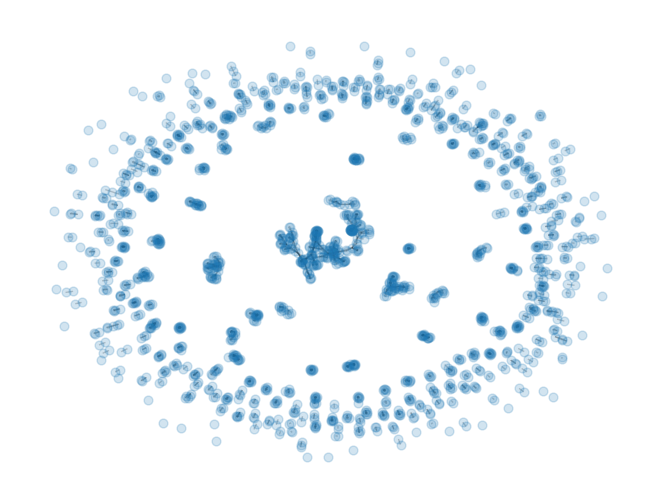

In [14]:
nx.draw(G,pos=pos, node_size=40,alpha=.2)

In [15]:
# JSON data generation function
def generate_json_data(G):
    # Convert the NetworkX graph to a JSON-serializable format
    data = nx.readwrite.json_graph.node_link_data(G)
    return data

In [16]:
# Call the function to generate JSON data
json_data = generate_json_data(G)

# Specify the file path where you want to save the JSON data
json_file_path = "author_network1.json"

# Save the JSON data to a file
with open(json_file_path, "w") as json_file:
    json.dump(json_data, json_file)

In [17]:
# Save the modified DataFrame to a new CSV file
df.to_csv("/content/sample_data/data_scopus_with_all_countries.csv", index=False)

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
